### Test robustness of VAE for perturbed spectra using different fudging and different segmentation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

# Set environment variables to disable multithreading as users will probably
# want to set the number of cores to the max of their computer.
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
###############################################################################
# Set TensorFlow print of log information
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


In [3]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
from anomaly.constants import GALAXY_LINES
from astroExplain.spectra.fudge import Fudge
from astroExplain.spectra.notebook import neighbors_explainer
from astroExplain.spectra.segment import SpectraSegmentation
from astroExplain.spectra.neighbors import SpectraNeighbors
from astroExplain.spectra.notebook import spectrum_in_segments
from autoencoders.ae import AutoEncoder
from anomaly.utils import specobjid_to_idx
from sdss.metadata import MetaData
from sdss.utils.managefiles import FileDirectory

meta = MetaData()
%matplotlib inline

In [104]:
def plot_neighbor(
    wave,
    spectrum,
    neighbor,
    neighbor_reconstruction,
    figsize: tuple= (10, 9)
):

    fig, axs = plt.subplots(nrows=2, ncols=1,figsize=figsize)

    axs[0].plot(wave, spectrum, color="black", label="original")
    axs[0].plot(wave, neighbor, color="red", alpha=0.4, label="sample")
    axs[0].set_ylabel("Normalized flux")


    axs[1].plot(wave, spectrum, color="black", alpha=1, label="original")
    axs[1].plot(wave, neighbor_reconstruction, color="red", alpha=0.4, label="sample reconstruction")

    axs[1].set_ylabel("Normalized flux")
    axs[1].set_xlabel("$\lambda$ [$\AA$]")

    # axs[2].plot(wave, neighbor_reconstruction, color="black", alpha=1, label="neighbor reconstruction")
    # axs[2].plot(wave, neighbor, color="red", alpha=0.6, label="neighbor")

    for ax in axs: ax.legend()

    return fig, axs

def show_segmentation(
    wave: np.array,
    spectrum: np.array,
    segmentation:np.array,
    number_segments: int=100,
    figsize: tuple= (10, 6)
):

    segmenter = SpectraSegmentation()

    if segmentation == "uniform":
        
        segmentation_function = segmenter.uniform

    elif segmentation == "kmeans":
        
        segmentation_function = segmenter.kmeans

    else:
        print(f"Segmenation {segmentation} not defined")
        sys.exit()

    segments = segmentation_function(spectrum, number_segments=number_segments)
    segmented_spectrum = spectrum_in_segments(spectrum, segments)
    
    number_segments = np.unique(segments).size
    print(f"Number of segments: {number_segments}")
    
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_xlabel("$\lambda$ [$\AA$]")
    ax.set_ylabel("Normalized flux")
    ax.set_title(
        f"Segmentation: {segmentation}\n"
        f"Number of segments {number_segments}"
    )

    for segment in segmented_spectrum:
        ax.plot(wave, segment)
    
    return fig, ax

In [5]:
# config
bin_id = "bin_04"
model_id = "0013"
architecture = "256_128_64/latent_12"
meta_data_directory = "/home/edgar/spectra/0_01_z_0_5_4_0_snr_inf"
model_directory = f"{meta_data_directory}/{bin_id}/models/{architecture}/{model_id}"
explanations_directory = f"{meta_data_directory}/{bin_id}/explanation/{architecture}"

In [6]:
# load data
wave = np.load(f"{meta_data_directory}/wave.npy")
meta_data_df = pd.read_csv(f"{meta_data_directory}/0_01_z_0_5_4_0_snr_inf.csv.gz", index_col="specobjid")
model = AutoEncoder(reload=True, reload_from=model_directory)

## Explore different fudging and segmentation

In [7]:
spectra = np.load(f"{meta_data_directory}/spectra.npy", mmap_mode="r")
idx_id = np.load(f"{meta_data_directory}/{bin_id}/{bin_id}_index_specobjid.npy")
# load MSE score of most normal galaxies, AKA, best reconstructed ones
normal_mse_df = pd.read_csv(
    f"{explanations_directory}/mse_noRel100/top_normal.csv.gz", index_col="specobjid"
)

## Explore some archetypical spectra

In [172]:
fudge_parameters = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.8,
# flat
    "continuum": 1,
# gaussians
    "amplitude":0.2,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0.05
}
segmentation = "kmeans"
# specobjid = 969534273977608192
# idx_spectrum = specobjid_to_idx(specobjid, idx_id)
# spectrum = spectra[idx_spectrum]
spectrum = spectra[idx_id[-2000, 0]]
number_segments = 64
neighbors = neighbors_explainer(
    number_samples=100,
    spectrum=spectrum,
    segmentation=segmentation,
    number_segments=number_segments,
    fudge_parameters=fudge_parameters,
)

Number of segments: 55


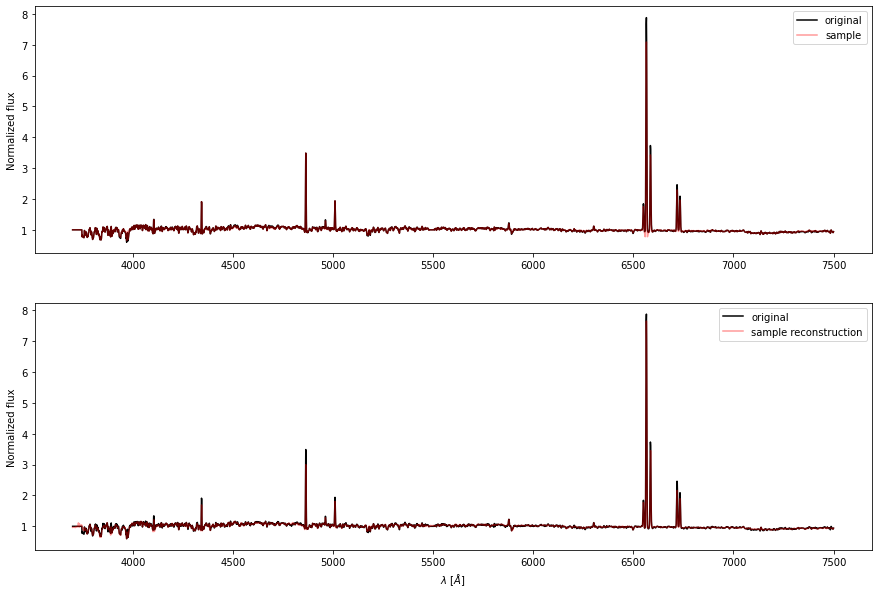

In [173]:
neighbor_id = 4
neighbor_reconstruction = model.reconstruct(neighbors[neighbor_id]).reshape(-1)
fig, axs = plot_neighbor(
    wave,
    spectrum=neighbors[0],
    neighbor=neighbors[neighbor_id],
    neighbor_reconstruction=neighbor_reconstruction, 
    figsize=(15, 10)
)
# fig.suptitle(
#     "LimeSpectraexplainer Neighbor \n"
#     f"Segmentation: {segmentation} \n"
#     f"Fudging: {fudge_parameters['kind_of_fudge']}"
# )

Number of segments: 22


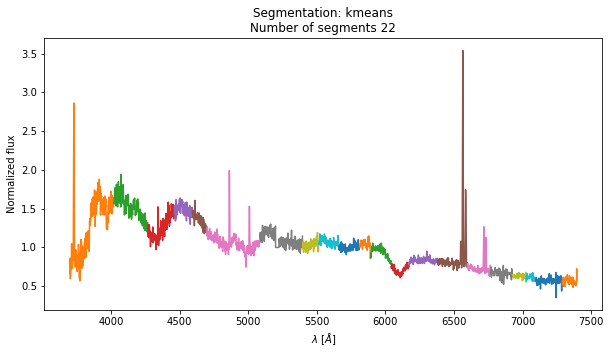

In [193]:
# -1000 and -2000
# spectrum = spectra[idx_id[-2000, 0]]
idx_spectrum = specobjid_to_idx(531492683672217600, idx_id)
spectrum = spectra[idx_spectrum]
fig, ax = show_segmentation(
    wave=wave,
    spectrum=spectrum,
    segmentation="kmeans",
    number_segments=32,
    figsize=(10, 5)
)

In [47]:
fudge_parameters = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "flat",
# scale
    "scale_factor": 0.01,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 1
}

spectrum = spectra[idx_id[54, 0]]
number_segments = 12

neighbors = neighbors_explainer(
    number_samples=100,
    spectrum=spectrum,
    segmentation="uniform",
    number_segments=number_segments,
    fudge_parameters=fudge_parameters,
)

Number of segments: 12


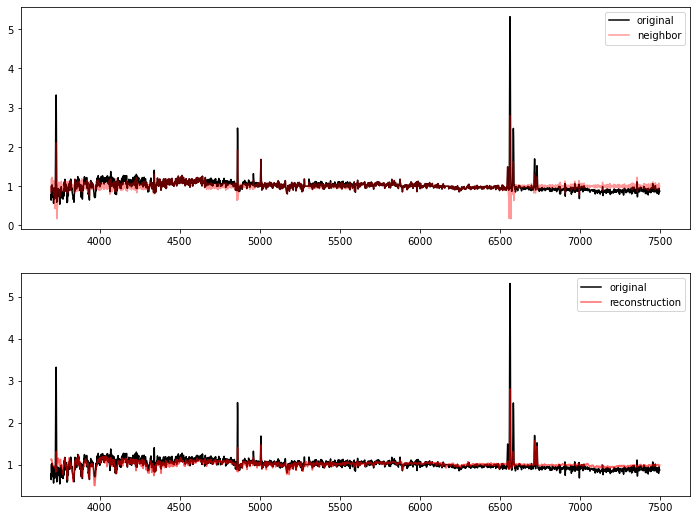

In [48]:
neighbor_id = 12
neighbor_reconstruction = model.reconstruct(neighbors[neighbor_id]).reshape(-1)
fig, axs = plot_neighbor(
    wave,
    spectrum=neighbors[0],
    neighbor=neighbors[neighbor_id],
    neighbor_reconstruction=neighbor_reconstruction, 
    figsize=(12, 9)
)

## Explore some anomalies

In [49]:
fudge_parameters = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.9,
# flat
    "continuum": 1,
# gaussians
    "amplitude":100.,
    "sigmas_in_segment": 2,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0.05
}
idx_spectrum = specobjid_to_idx(531492683672217600, idx_id)
spectrum = spectra[idx_spectrum]

number_segments = 12

neighbors = neighbors_explainer(
    number_samples=100,
    spectrum=spectrum,
    segmentation="uniform",
    number_segments=number_segments,
    fudge_parameters=fudge_parameters,
)


Number of segments: 12


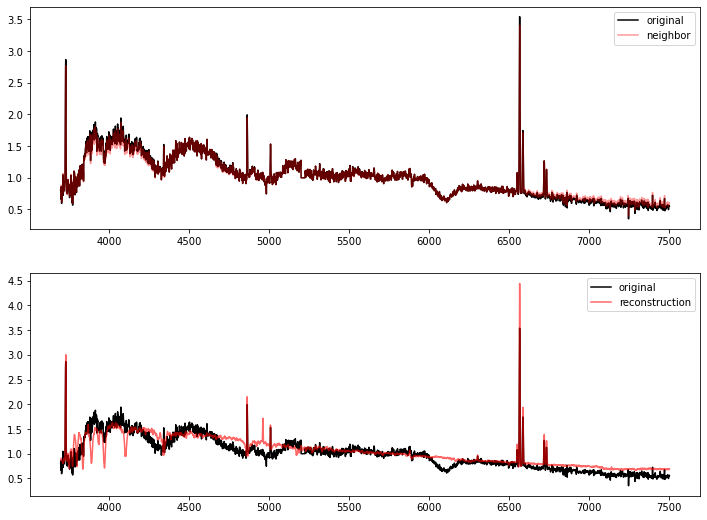

In [51]:
neighbor_id = 12
neighbor_reconstruction = model.reconstruct(neighbors[neighbor_id]).reshape(-1)
fig, axs = plot_neighbor(
    wave,
    spectrum=neighbors[0],
    neighbor=neighbors[neighbor_id],
    neighbor_reconstruction=neighbor_reconstruction, 
    figsize=(12, 9)
)

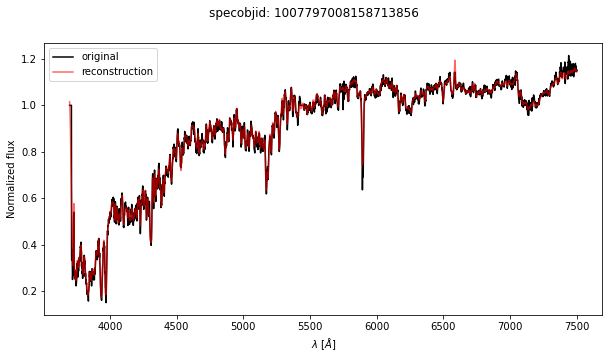

In [189]:
spectrum_id = idx_id[-1000, 0]
specobjid = idx_id[-1000, 1]
spectrum = spectra[spectrum_id]
reconstruction = model.reconstruct(spectrum).reshape(-1)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(wave, spectrum, color="black", label="original")
ax.plot(wave, reconstruction, color="red", alpha=0.6, label="reconstruction")
fig.suptitle(f"specobjid: {specobjid}")
ax.set_xlabel("$\lambda$ [$\AA$]")
ax.set_ylabel("Normalized flux")
ax.legend()

'http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=531492683672217600&apid='

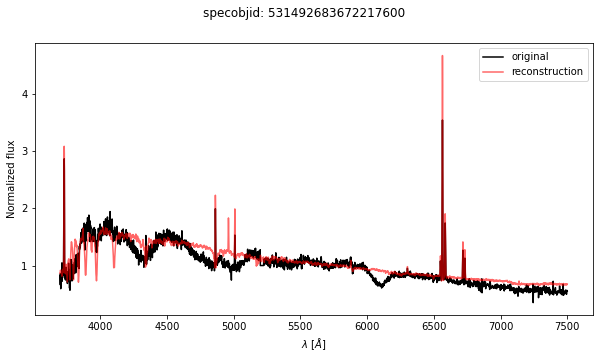

In [191]:
specobjid = 531492683672217600
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]
reconstruction = model.reconstruct(spectrum).reshape(-1)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(wave, spectrum, color="black", label="original")
ax.plot(wave, reconstruction, color="red", alpha=0.6, label="reconstruction")
fig.suptitle(f"specobjid: {specobjid}")
ax.set_xlabel("$\lambda$ [$\AA$]")
ax.set_ylabel("Normalized flux")
ax.legend()
meta.get_sky_server_url(specobjid)